The following code imports standard python libraries

In [1]:
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import h5py

import torch.fft
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

# following for displaying images in notebook
from torchvision.transforms import ToPILImage
from IPython.display import Image
to_img = ToPILImage()

The following are the settings used, L and Lf are latent dimensions of the first and second autoencoders.
Kc is the number of clusters
Khp is the order of k-harmonic mean cost function, usually a value in 2..4. The patch size of the images used in training is given by patch_size. The number of input channels XX(real,imag) YY(real,imag) is 4, it is also possible to use all 4 correlations XX,XY,YX,YY when num_in_channels should be 8.

In [2]:
L=256 # latent dimension
Lf=64 # latent dimension
Kc=10 # clusters
Khp=4 # order of K harmonic mean 1/|| ||^p norm

patch_size=128
num_in_channels=4 # real,imag XX,YY

We import the neural networks models used here

In [3]:
from lofar_models import *


We create the models and initialize them with the saved models.

In [4]:
net=AutoEncoderCNN2(latent_dim=L,channels=num_in_channels)
# fft: real,imag, so increase number of channels by x2
fnet=AutoEncoderCNN2(latent_dim=Lf,channels=2*num_in_channels)
mod=Kmeans(latent_dim=(L+Lf),p=Khp)

checkpoint=torch.load('./net.model',map_location=torch.device('cpu'))
net.load_state_dict(checkpoint['model_state_dict'])
checkpoint=torch.load('./fnet.model',map_location=mydevice)
fnet.load_state_dict(checkpoint['model_state_dict'])
checkpoint=torch.load('./khm.model',map_location=torch.device('cpu'))
mod.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

Display the clustering model

In [5]:
torchvision.utils.save_image(mod.M.data,'M.png')
Image('M.png')

Specify data files here, I used a list of h5 files and a matching list of SAP Ids.

In [6]:
torchvision.utils.save_image(mod.M.data,'M.png')
file_list=['/home/sarod/L785751.MS_extract.h5','/home/sarod/L785751.MS_extract.h5',
   '/home/sarod/L785747.MS_extract.h5', '/home/sarod/L785757.MS_extract.h5',
   '/home/sarod/L696315.MS_extract.h5', '/home/sarod/L696315.MS_extract.h5',
   '/home/sarod/L686974.MS_extract.h5', '/home/sarod/L686974.MS_extract.h5']
sap_list=['1','2','0','0','1','2','1','2']


which_sap=2 # valid in file_list/sap_list

Get the dimensions of the dataset

In [7]:
# get nbase,nfreq,ntime,npol,ncomplex
nbase,nfreq,ntime,npol,ncomplex=get_metadata(file_list[which_sap],sap_list[which_sap])
# limit the max number of baselines if time is limited
nbase=100

Create storage for creating t-SNE plot later

In [8]:
X=np.zeros([Kc,nbase],dtype=np.float)
clusid=np.zeros(nbase,dtype=np.float)

Iterate over the baselines, load each baseline as a minibatch, feed it to the network, and get clustering weights.

In [9]:
for nb in range(nbase):
    patchx,patchy,x=get_data_for_baseline(file_list[which_sap],sap_list[which_sap],baseline_id=nb,patch_size=128,num_channels=num_in_channels)
    # get latent variable
    xhat,mu=net(x)
    # perform 2D fft
    fftx=torch.fft.fftn(x-xhat,dim=(2,3),norm='ortho')
    # fftshift
    freal,fimag=torch_fftshift(fftx.real,fftx.imag)
    y=torch.cat((freal,fimag),1)
    yhat,ymu=fnet(y)
    torchvision.utils.save_image( torch.cat((torch.cat((x[0,1],xhat[0,1])),(patch_size*patch_size)*torch.cat((y[0,1],yhat[0,1]))),1).data, 'xx_'+str(nb)+'.png' )
    Mu=torch.cat((mu,ymu),1)
    kdist=mod(Mu)
    (nbatch,_)=Mu.shape
    dist=torch.zeros(Kc)
    for ck in range(Kc):
        for cn in range(nbatch):
            dist[ck]=dist[ck]+(torch.norm(Mu[cn,:]-mod.M[ck,:],2))
    dist=dist/nbatch
    X[:,nb]=dist.detach().numpy()
    (values,indices)=torch.min(dist.view(Kc,1),0)
    print('%d %f %d'%(nb,kdist,indices[0]))
    clusid[nb]=indices[0]
    vis=get_data_for_baseline_flat(file_list[which_sap],sap_list[which_sap],baseline_id=nb,num_channels=num_in_channels)
    torchvision.utils.save_image(vis[0,0].data, 'b'+str(indices[0].data.item())+'_'+str(nb)+'.png')


0 0.005159 8
1 0.005117 8
2 0.006691 8
3 0.008891 5
4 0.005231 8
5 0.005970 8
6 0.004939 5
7 0.004689 5
8 0.005698 0
9 0.006828 8
10 0.005541 5
11 0.005472 5
12 0.005844 8
13 0.005115 8
14 0.005403 8
15 0.005564 8
16 0.006432 8
17 0.006621 8
18 0.005236 8
19 0.005121 8
20 0.007757 8
21 0.008860 5
22 0.006613 8
23 0.006191 8
24 0.006345 5
25 0.008021 5
26 0.011630 5
27 0.011019 5
28 0.006115 8
29 0.006642 8
30 0.004813 8
31 0.004755 0
32 0.006986 0
33 0.006341 8
34 0.005443 8
35 0.005369 8
36 0.006484 5
37 0.006544 5
38 0.004958 5
39 0.005105 0
40 0.008135 5
41 0.007903 5
42 0.006629 5
43 0.006677 5
44 0.004651 0
45 0.006081 0
46 0.004508 8
47 0.004589 5
48 0.010396 5
49 0.010165 0
50 0.015381 0
51 0.016889 0
52 0.011225 5
53 0.009565 5
54 0.012865 0
55 0.013222 5
56 0.009340 5
57 0.009937 5
58 0.024482 0
59 0.011352 5
60 0.009397 5
61 0.010089 0
62 0.011953 8
63 0.011912 7
64 0.010551 5
65 0.010888 5
66 0.008978 7
67 0.009874 0
68 0.011737 8
69 0.006474 7
70 0.007797 8
71 0.005972 8
72

Display some of the results first

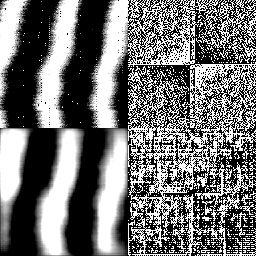

In [10]:
Image('xx_51.png')

Create t-SNE plot

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.000s...
[t-SNE] Computed neighbors for 100 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 0.362065
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.898273
[t-SNE] KL divergence after 1000 iterations: 0.113831


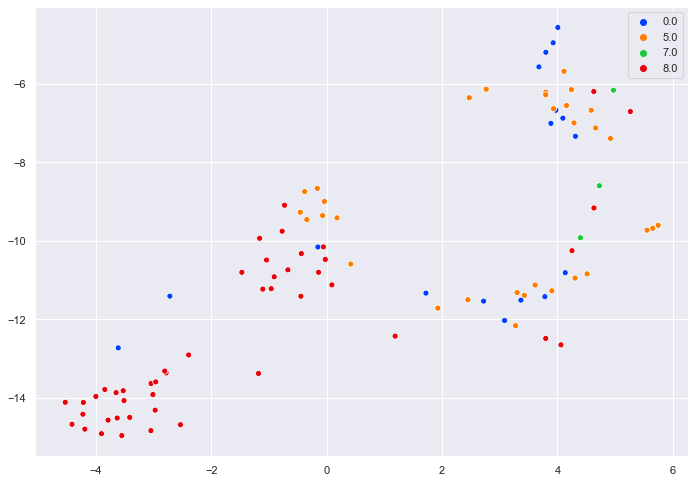

In [11]:
tsne=TSNE(verbose=True)
X_emb=tsne.fit_transform(X.transpose())
uniq=np.unique(clusid)
snsplot=sns.scatterplot(X_emb[:,0], X_emb[:,1], hue=clusid, legend='full',
  palette = sns.color_palette("bright", n_colors=len(uniq)))
snsplot.figure.savefig('scatter.png')